# 1. Install PIP's

In [1]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
nlp = spacy.load('pt_core_news_lg')
import string
import regex as re
from unidecode import unidecode
from scipy import stats
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [3]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [4]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [8]:
selected_columns = ['review_id', 'review_score', 
                    'review_comment_message', 'review_creation_date', 
                    'geolocation_lat', 'geolocation_lng','geolocation_state']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [9]:
datetime_columns = ['review_creation_date']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Drop Duplicates

In [10]:
full_df = full_df.drop_duplicates(subset=['review_id'])

### 4.5. Drop NA

In [11]:
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

In [12]:
latest_date = full_df['review_creation_date'].max()
four_months_ago = latest_date - pd.DateOffset(months=1)


full_df = full_df[full_df['review_creation_date'] >= four_months_ago]
full_df.reset_index(drop=True, inplace=True)

# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [14]:
def to_lower(text):
    return text.lower()

In [15]:
full_df['text_sentiment'] = full_df['review_comment_message'].apply(to_lower)

### 5.2. Removing Punctuation, Exemple (".", "!")

In [17]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [18]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_punctuation)

### 5.3. Removing Emoji

In [19]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_emojis)

### 5.4. Removing Sites and Blogs

In [21]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [22]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_urls)

### 5.5. Removing Accentuation

In [23]:
def remove_accent(text):
    return unidecode(text)

In [24]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_accent)

### 5.6. Remove Numbers

In [25]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [26]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_numbers)

### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [27]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [28]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_broke_line)

### 5.8. Remove Blank Space Text

In [29]:
def strip_text(text):
    return text.strip()

In [30]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(strip_text)

### 5.9. Filter only Adjetivos, Verbos, Substantivo, Adverbios and "nao" "nada"

In [31]:
def filtrar_tokens(text):
    doc = nlp(text)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

In [32]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(filtrar_tokens)

### 5.10. Lematization

In [33]:
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [34]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lemmatize_text)

In [35]:
full_df = full_df.dropna(subset=['text_sentiment'])

In [36]:
print(len(full_df))

3576


In [39]:
full_df.head(5)

,review_id,review_score,review_comment_message,review_creation_date,geolocation_lat,geolocation_lng,geolocation_state,text_sentiment
0,8d5266042046a06655c8db133d120ba5,4,Muito bom o produto.,2018-08-08,-19.810119,-43.984727,MG,muito bom produto
1,9a55cbc65c8fad47581da5ebbb2b373e,5,Sempre vou comprar aqui pois é a melhor parabéns,2018-08-14,-21.728866,-48.688815,SP,sempre comprar aqui pois bom parabens
2,7fe86452ea24bb5085343b5e9d684a3e,5,Prazo de entrega excelente e produto cuidadosa...,2018-08-03,-23.615718,-46.531184,SP,prazo entregar excelente produto cuidadosament...
3,25b502beeef8b3aff87449ccdc001f53,1,"Recebi apenas 1 unidade solicitada, deveriam s...",2018-08-01,-23.661487,-46.564162,SP,recebi apenas unidade solicitar dever inclusiv...
4,eec56fe350a345430c241eec25016592,5,"Produto muito bonito, chegou no prazo correto ...",2018-08-29,-23.693986,-46.701883,SP,produto muito bonito chegar prazo correto pare...


# 6. Previus Analyze

In [41]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example
0,review_id,object,0,3576,8d5266042046a06655c8db133d120ba5
1,review_score,int64,0,5,4
2,review_comment_message,object,0,3363,Muito bom o produto.
3,review_creation_date,datetime64[ns],0,31,2018-08-08 00:00:00
4,geolocation_lat,float64,0,858,-19.810119
5,geolocation_lng,float64,0,858,-43.984727
6,geolocation_state,object,0,16,MG
7,text_sentiment,object,0,3048,muito bom produto


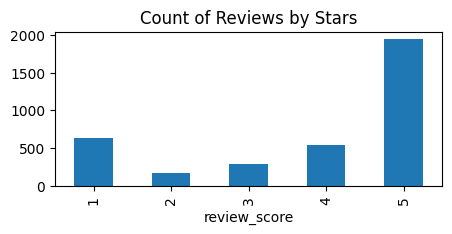

In [42]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [43]:
example = full_df['text_sentiment'].iloc[4]
print(example)

produto muito bonito chegar prazo correto parecer trofeu qualidade otimo presente


# 7. Deploy Dataframe Test

In [44]:
selected_columns = ['text_sentiment']
df_test = full_df.loc[:, selected_columns]

In [45]:
df_test.head(5)

,text_sentiment
0,muito bom produto
1,sempre comprar aqui pois bom parabens
2,prazo entregar excelente produto cuidadosament...
3,recebi apenas unidade solicitar dever inclusiv...
4,produto muito bonito chegar prazo correto pare...


In [82]:
import joblib

# Carregar o modelo MLPClassifier
analyze_sentiment = joblib.load('modelo_analyze_sentiment.pkl')

# Carregar o vetorizador
vectorizer = joblib.load('vectorizer.pkl')

# Carregar o normalizador
normalization = joblib.load('normalization.pkl')

### 7.5. Inicializing Training IA

In [84]:
pd.set_option('display.max_colwidth', None)

# Vetorizar os novos dados usando o mesmo vetorizador
comment_test_dtm = vectorizer.transform(df_test['text_sentiment'])

# Normalizar os dados usando o mesmo normalizador
X_test = normalization.transform(comment_test_dtm)

# Fazer previsões
predictions = analyze_sentiment.predict(X_test)

# Adicionar as previsões ao DataFrame original
df_test['predictions'] = predictions

display(df_test[['text_sentiment', 'predictions']])

,text_sentiment,predictions
0,muito bom produto,1
1,sempre comprar aqui pois bom parabens,1
2,prazo entregar excelente produto cuidadosamente embalar recomender,1
3,recebi apenas unidade solicitar dever inclusive cobrar constar nota fiscal tentar contato loja dia informar mandar email contato fornecer,0
4,produto muito bonito chegar prazo correto parecer trofeu qualidade otimo presente,1
...,...,...
3571,ainda nao chegar nao com si rastrear produto preciso codigo rastreamento,0
3572,vir td certo chegar mt antes certeza comprar novamente,1
3573,achar produto muito pequeno ficar tela botoes microondas sair facilidade nao ter bom encaixe,1
3574,muito bom produto,1


In [86]:
df_export = full_df.copy()
df_export['predictions'] = predictions
df_export[['review_id','review_comment_message','text_sentiment', 'review_score', '','geolocation_lat','geolocation_lng','geolocation_state','review_creation_date']].to_csv('dados_processados.csv', index=False)predictions

In [88]:
df_export.head(5)

,review_id,review_score,review_comment_message,review_creation_date,geolocation_lat,geolocation_lng,geolocation_state,text_sentiment,predictions
0,8d5266042046a06655c8db133d120ba5,4,Muito bom o produto.,2018-08-08,-19.810119,-43.984727,MG,muito bom produto,1
1,9a55cbc65c8fad47581da5ebbb2b373e,5,Sempre vou comprar aqui pois é a melhor parabéns,2018-08-14,-21.728866,-48.688815,SP,sempre comprar aqui pois bom parabens,1
2,7fe86452ea24bb5085343b5e9d684a3e,5,Prazo de entrega excelente e produto cuidadosamente embalado! Recomendo!,2018-08-03,-23.615718,-46.531184,SP,prazo entregar excelente produto cuidadosamente embalar recomender,1
3,25b502beeef8b3aff87449ccdc001f53,1,"Recebi apenas 1 unidade solicitada, deveriam ser 2, inclusive foi cobrado e consta na nota fiscal. Estou tentando contato com a loja a 4 dias. Informam que vão me mandar por email o contato do fornece",2018-08-01,-23.661487,-46.564162,SP,recebi apenas unidade solicitar dever inclusive cobrar constar nota fiscal tentar contato loja dia informar mandar email contato fornecer,0
4,eec56fe350a345430c241eec25016592,5,"Produto muito bonito, chegou no prazo correto parece um Trofeu, qualidade ótimo para presente",2018-08-29,-23.693986,-46.701883,SP,produto muito bonito chegar prazo correto parecer trofeu qualidade otimo presente,1


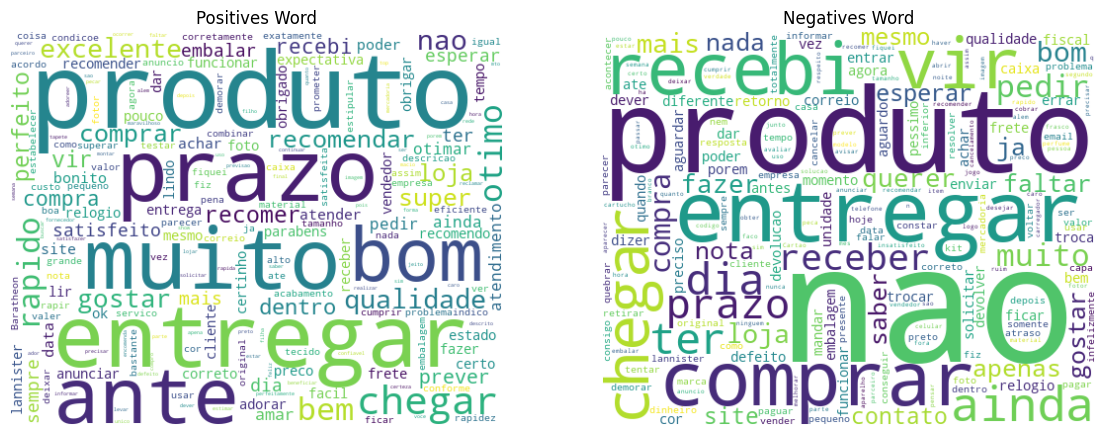

In [90]:
# Juntar todas as palavras dos textos mais positivos e mais negativos
Most_Positive_text = ' '.join(df_export[df_export['predictions'] == 1]['text_sentiment'])
Most_Negative_text = ' '.join(df_export[df_export['predictions'] == 0]['text_sentiment'])

# Criar as nuvens de palavras
pwc = WordCloud(width=500, height=400, collocations=False, background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=500, height=400, collocations=False, background_color='white').generate(Most_Negative_text)

# Plotar as nuvens de palavras
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(pwc, interpolation='bilinear')
plt.title('Positives Word', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nwc, interpolation='bilinear')
plt.title('Negatives Word', fontsize=12)
plt.axis('off')

plt.show()

In [93]:
# Filtrar mensagens positivas e negativas
mensagens_positivas = df_export[df_export['predictions'] == 1]['text_sentiment']
mensagens_negativas = df_export[df_export['predictions'] == 0]['text_sentiment']

def contar_palavras(mensagens, sentiment):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    
    # Criando o DataFrame
    df_contagem = pd.DataFrame(contagem_palavras.most_common(60), columns=['word', 'count'])
    df_contagem['sentiment'] = sentiment
    return df_contagem

# Contar palavras mais comuns para mensagens positivas
df_positivas = contar_palavras(mensagens_positivas, 1)

# Contar palavras mais comuns para mensagens negativas
df_negativas = contar_palavras(mensagens_negativas, 0)

# Concatenar os DataFrames
df_final = pd.concat([df_positivas, df_negativas])

In [95]:
df_final.to_csv('countdeploy.csv')

In [94]:
df_final.head(5)

,word,count,sentiment
0,produto,1002,1
1,entregar,647,1
2,prazo,641,1
3,muito,606,1
4,antes,515,1
